In [14]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader
from trainer import Trainer
from datasets import UnderwaterCreaturesMultiLabelDataset, collate_fn
from torch.utils.data import DataLoader
from trainer import Trainer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# root directory
class_names = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
num_classes = len(class_names)
root_dir = 'datasets/aquarium-data-cots/aquarium_pretrain'

# datasets
train_dataset = UnderwaterCreaturesMultiLabelDataset(root_dir, split='train', num_classes=num_classes)
valid_dataset = UnderwaterCreaturesMultiLabelDataset(root_dir, split='valid', num_classes=num_classes)
test_dataset = UnderwaterCreaturesMultiLabelDataset(root_dir, split='test', num_classes=num_classes)

# dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [16]:
# fine-tinue ResNet18 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)  # 7 classes
model = model.to(device)

# loss and optimizer
# Train the model
num_epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# initialize trainer
trainer = Trainer(model, device, criterion, optimizer, num_classes=len(class_names), class_names=class_names)

/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Training Loss: 0.5604
Validation Loss: 0.4403
Epoch 2/20, Training Loss: 0.2985
Validation Loss: 0.3119
Epoch 3/20, Training Loss: 0.1795
Validation Loss: 0.2426
Epoch 4/20, Training Loss: 0.1189
Validation Loss: 0.1949
Epoch 5/20, Training Loss: 0.0825
Validation Loss: 0.1761
Epoch 6/20, Training Loss: 0.0607
Validation Loss: 0.1578
Epoch 7/20, Training Loss: 0.0495
Validation Loss: 0.1462
Epoch 8/20, Training Loss: 0.0386
Validation Loss: 0.1500
Epoch 9/20, Training Loss: 0.0337
Validation Loss: 0.1496
Epoch 10/20, Training Loss: 0.0272
Validation Loss: 0.1460
Epoch 11/20, Training Loss: 0.0212
Validation Loss: 0.1421
Epoch 12/20, Training Loss: 0.0198
Validation Loss: 0.1429
Epoch 13/20, Training Loss: 0.0157
Validation Loss: 0.1412
Epoch 14/20, Training Loss: 0.0149
Validation Loss: 0.1398
Epoch 15/20, Training Loss: 0.0145
Validation Loss: 0.1417
Epoch 16/20, Training Loss: 0.0125
Validation Loss: 0.1443
Epoch 17/20, Training Loss: 0.0121
Validation Loss: 0.1398
Epoch 

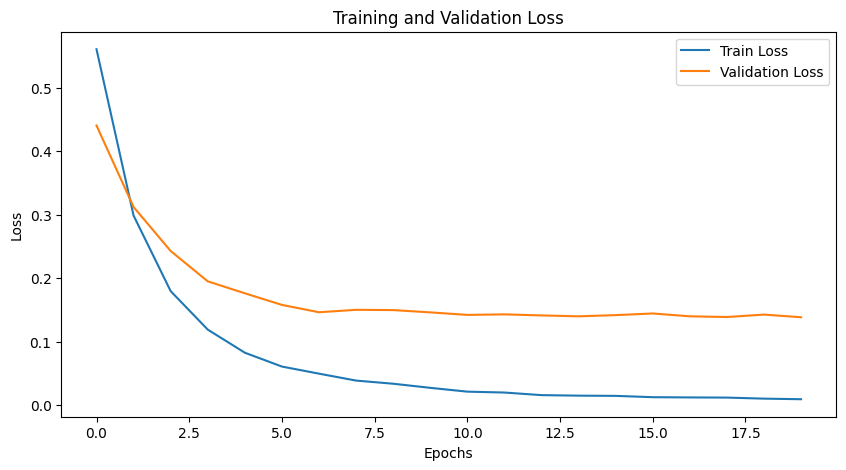

Class fish AP: 0.9604
Class jellyfish AP: 1.0000
Class penguin AP: 0.8826
Class puffin AP: 1.0000
Class shark AP: 0.8187
Class starfish AP: 0.8940
Class stingray AP: 0.9418
mAP: 0.9282


In [9]:
# train
trainer.train(train_loader, valid_loader, num_epochs=num_epochs)

# plot loss curves
trainer.plot_metrics()

# get precisions and avg precision
val_targets, val_outputs, average_precisions, mAP = trainer.evaluate_metrics(valid_loader)

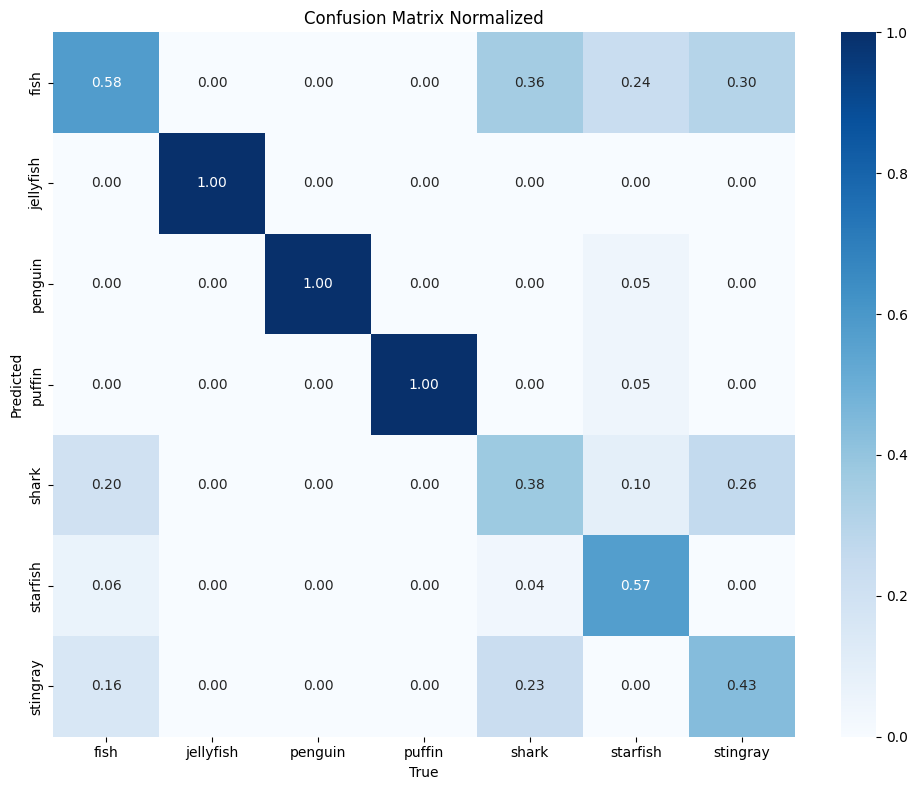

In [10]:
# plot confusion matrix on val set
confusion_matrix_test = trainer.compute_confusion_matrix(val_targets, val_outputs, threshold=0.5)
trainer.plot_pairwise_confusion_matrix(confusion_matrix_test, class_names, epoch=num_epochs, threshold=0.5)

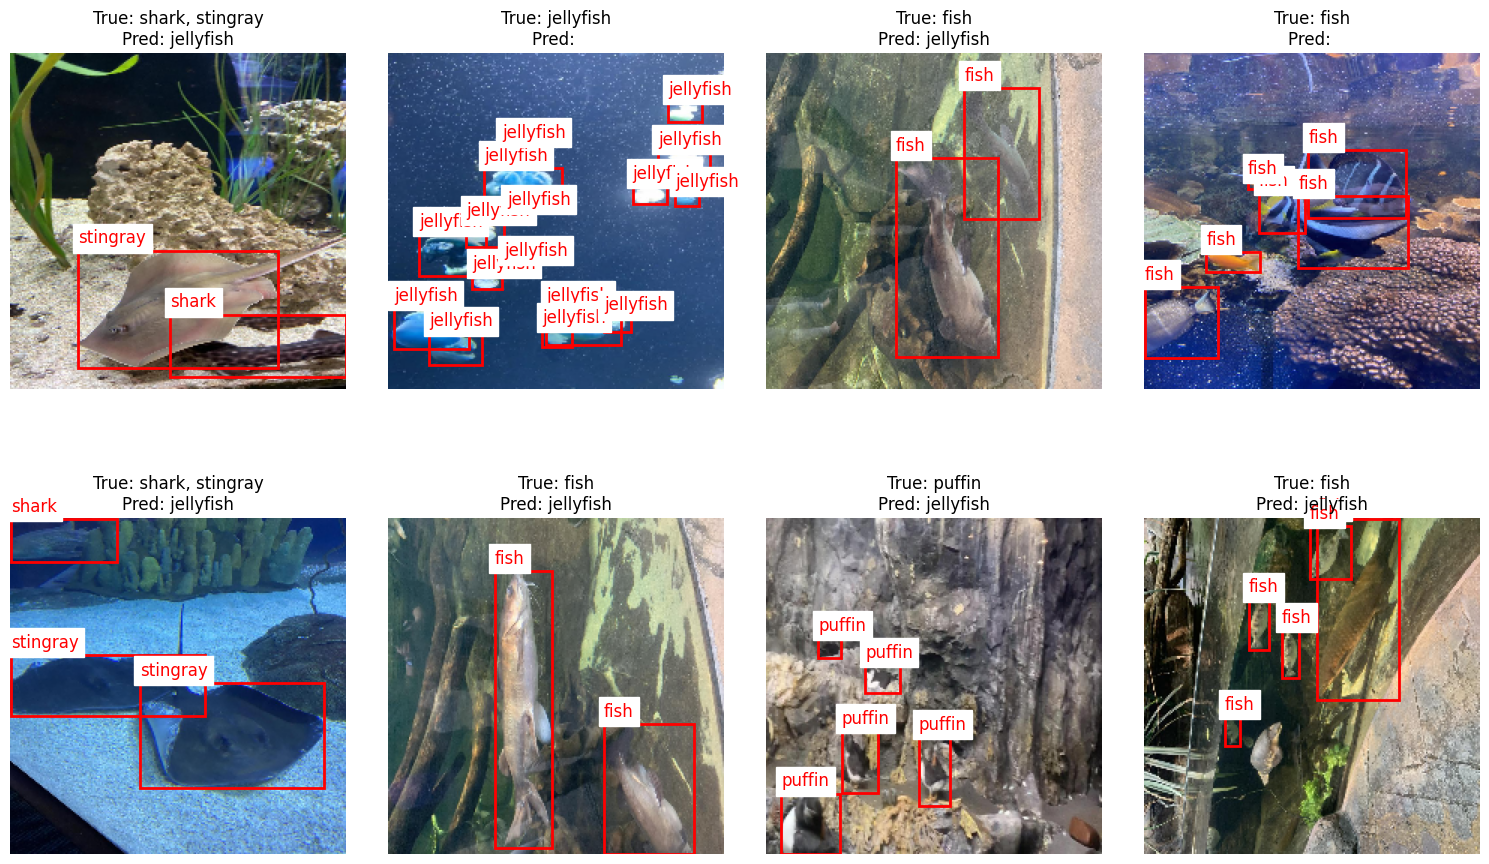

In [17]:
# Visualize predictions on validation set
trainer.visualize_predictions(valid_loader, num_images=8, threshold=0.8)